# Analysis of the EALSTM results

In [1]:
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [2]:
import sys
sys.path.append('../..')
from src.analysis import plot_shap_values, annual_r2_scores, plot_predictions

## R^2 analysis

In [3]:
monthly_scores = annual_r2_scores(data_path=Path('../../data'), models=['ealstm'], pred_year=2018)

For month 1, model ealstm has r2 score 0.6667458133933016
For month 2, model ealstm has r2 score 0.37416170182209285
For month 3, model ealstm has r2 score -0.4554208093052674
For month 4, model ealstm has r2 score 0.03753531461136039
For month 5, model ealstm has r2 score 0.490135570764365
For month 6, model ealstm has r2 score 0.6043983272796123
For month 7, model ealstm has r2 score 0.4935939277322886
For month 8, model ealstm has r2 score 0.5954758257994821
For month 9, model ealstm has r2 score 0.6015175136565054
For month 10, model ealstm has r2 score 0.5152474342975926
For month 11, model ealstm has r2 score 0.4464808329079474
For month 12, model ealstm has r2 score 0.5418611060679067


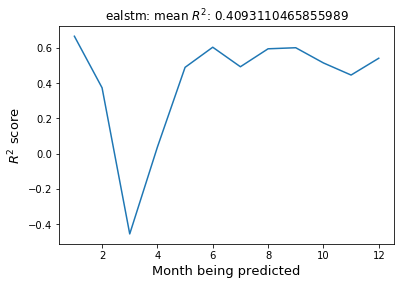

In [4]:
for model in ['ealstm']:
    plt.clf()
    plt.plot(monthly_scores['month'], monthly_scores[model])
    plt.xlabel('Month being predicted', size=13)
    plt.ylabel('$R^2$ score', size=13)
    plt.title(f'{model}: mean $R^2$: {np.mean(monthly_scores[model])}')
    plt.show()

For month 1, ealstm error: 7.38448880482924


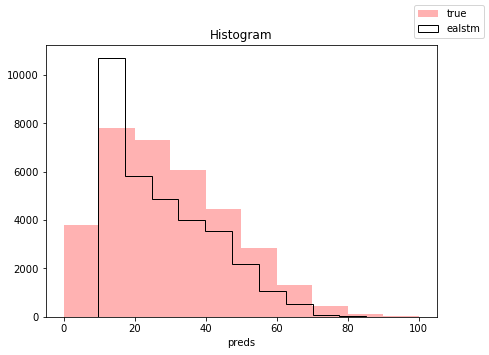

<Figure size 432x288 with 0 Axes>

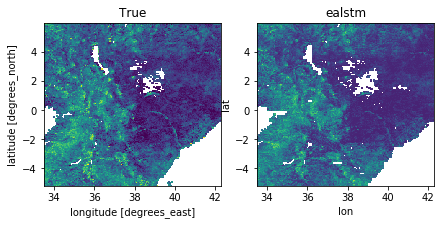

For month 2, ealstm error: 10.276761182787611


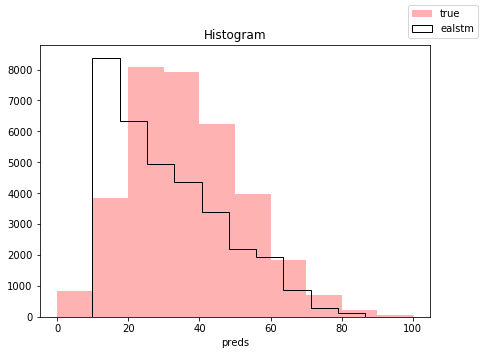

<Figure size 432x288 with 0 Axes>

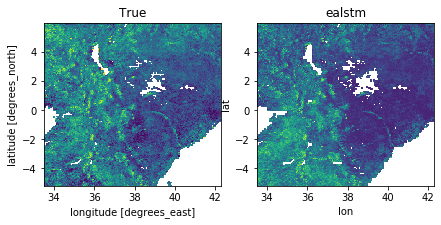

For month 3, ealstm error: 15.766933499450095


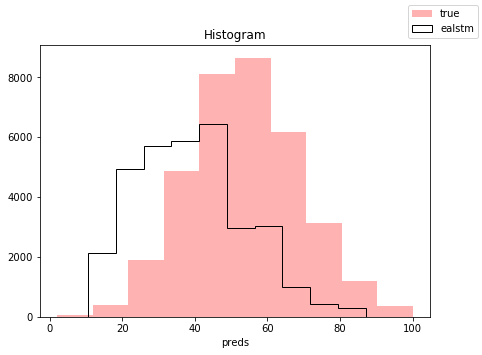

<Figure size 432x288 with 0 Axes>

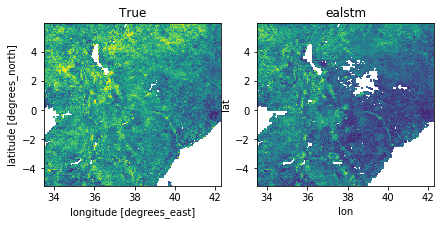

For month 4, ealstm error: 11.627567063038654


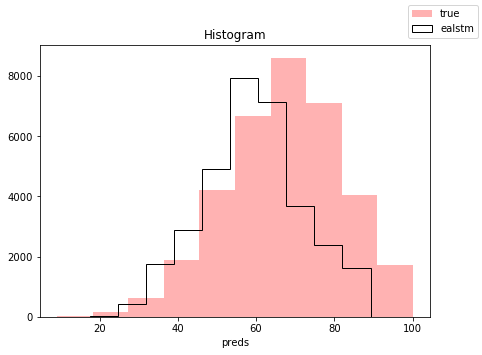

<Figure size 432x288 with 0 Axes>

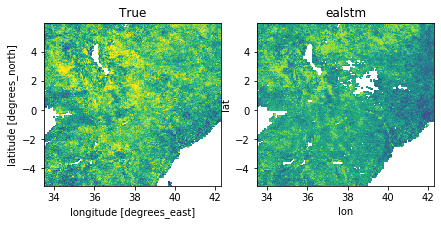

For month 5, ealstm error: 9.077697533854195


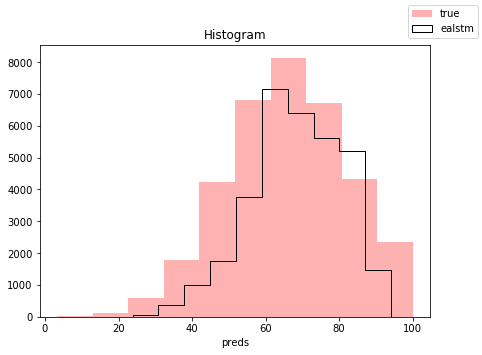

<Figure size 432x288 with 0 Axes>

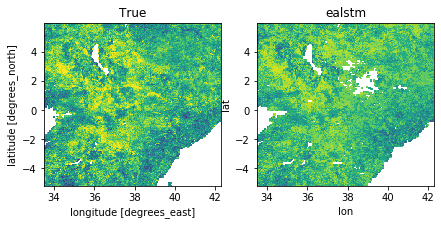

For month 6, ealstm error: 7.956112158819365


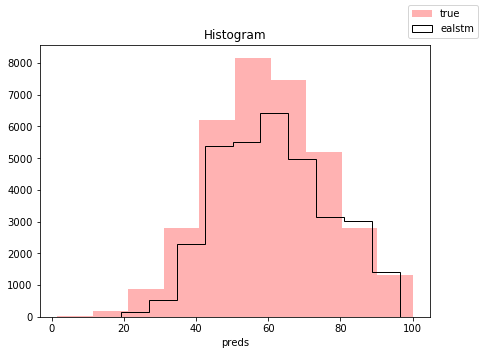

<Figure size 432x288 with 0 Axes>

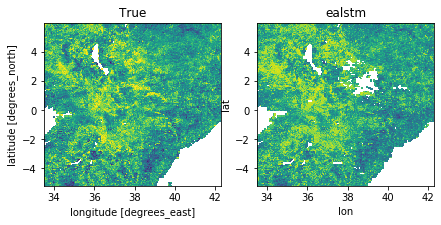

For month 7, ealstm error: 9.070781356443426


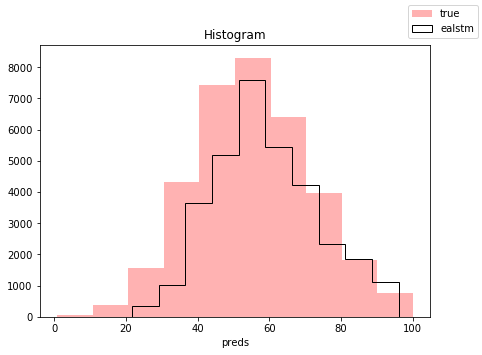

<Figure size 432x288 with 0 Axes>

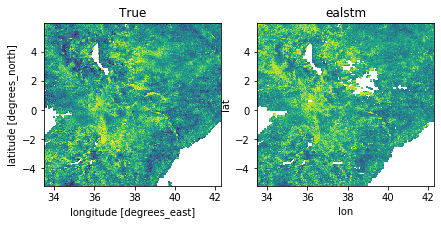

For month 8, ealstm error: 8.679208222296909


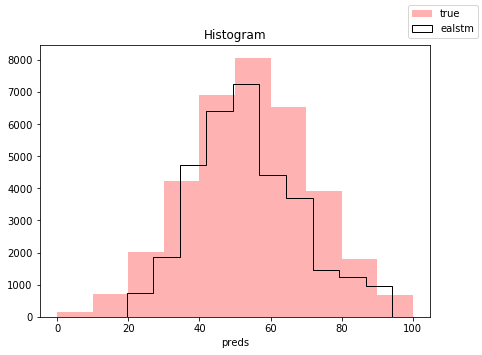

<Figure size 432x288 with 0 Axes>

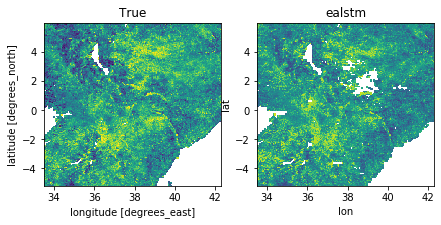

For month 9, ealstm error: 8.580206775749188


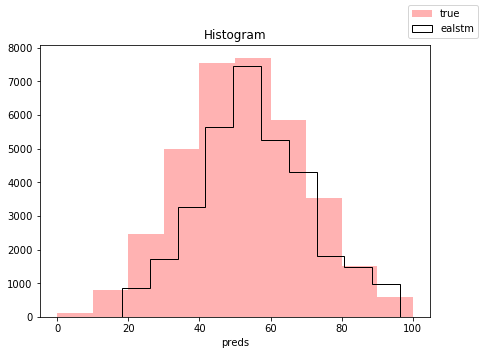

<Figure size 432x288 with 0 Axes>

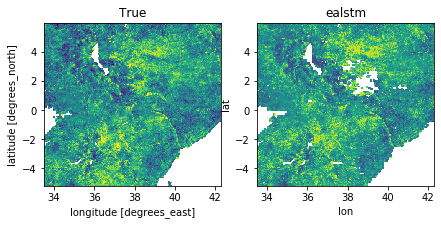

For month 10, ealstm error: 8.684806897247107


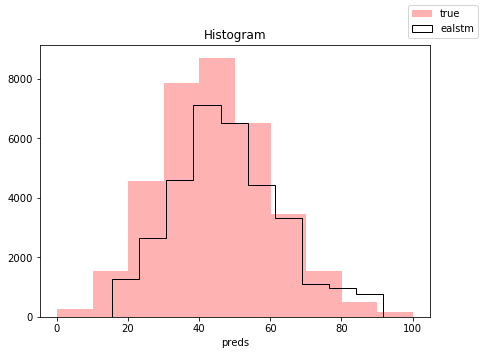

<Figure size 432x288 with 0 Axes>

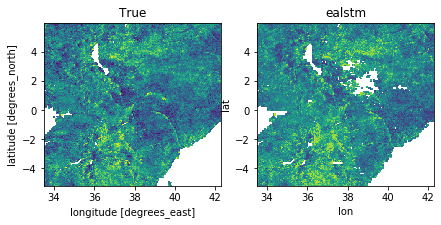

For month 11, ealstm error: 9.160954836702542


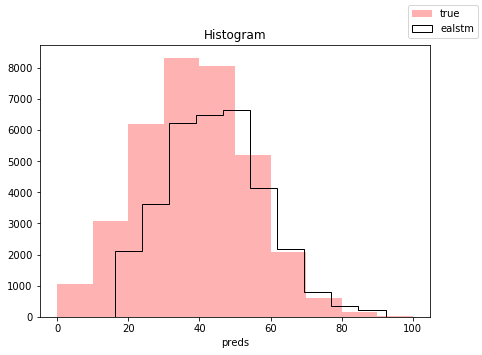

<Figure size 432x288 with 0 Axes>

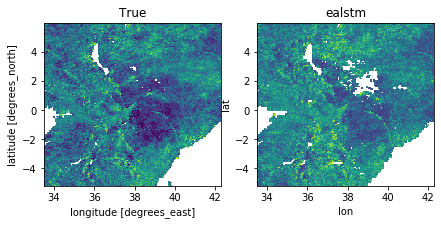

For month 12, ealstm error: 8.07491777602407


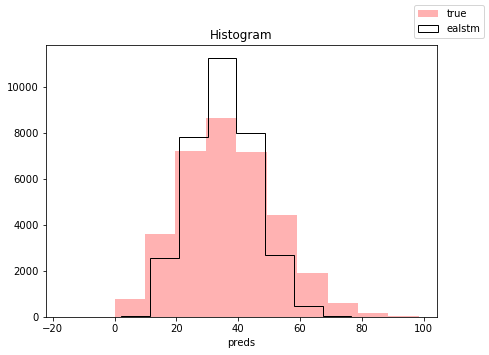

<Figure size 432x288 with 0 Axes>

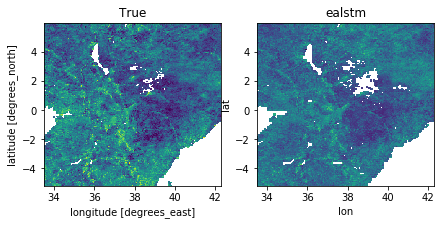

In [3]:
for i in range(1, 13):
    plot_predictions(pred_month=i, data_path=Path('../../data'), model='ealstm')

In [3]:
analysis_dir = Path('../../data') / 'models/one_month_forecast/ealstm/analysis'

In [4]:
shap_historical = np.load(analysis_dir / 'shap_value_historical.npy')
input_historical = np.load(analysis_dir / 'input_historical.npy')
with (analysis_dir / 'input_variable_names.pkl').open('rb') as f:
    variable_names = pickle.load(f)
with (Path('../../data') / 'features/one_month_forecast/normalizing_dict.pkl').open('rb') as f:
    norm_dict = pickle.load(f)

In [5]:
shap_pred_months = shap_static = np.load(analysis_dir / 'shap_value_pred_months.npy')
input_pred_months = np.load(analysis_dir / 'input_pred_months.npy')

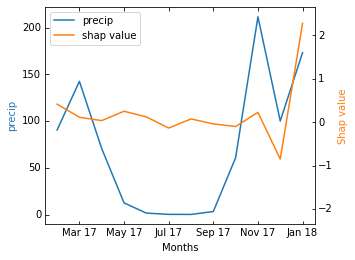

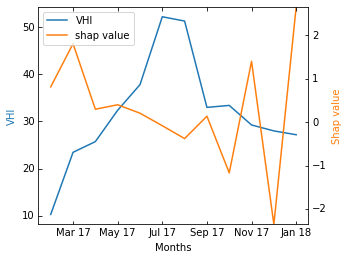

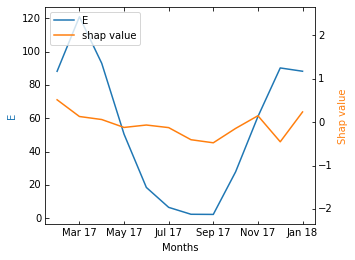

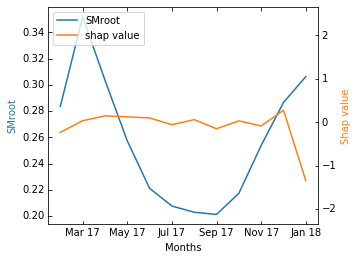

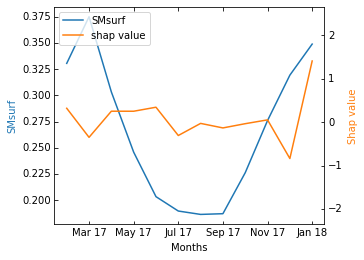

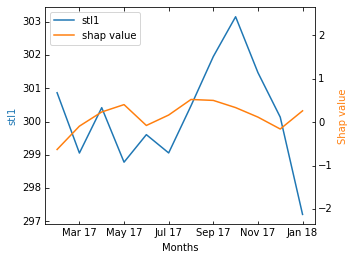

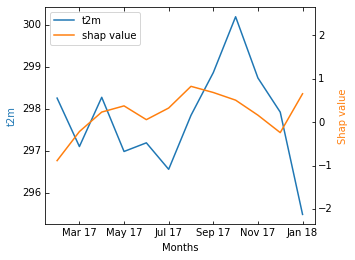

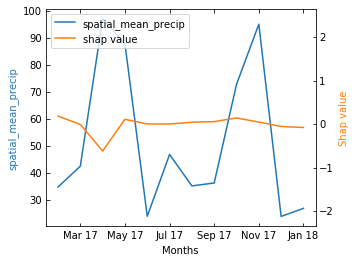

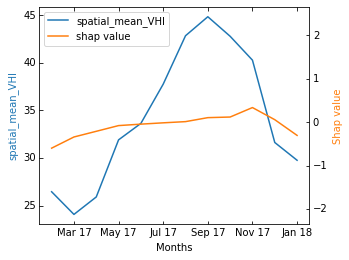

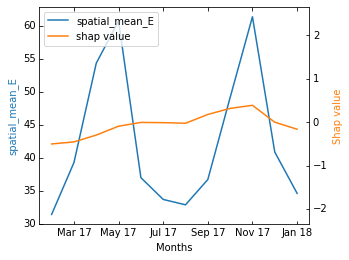

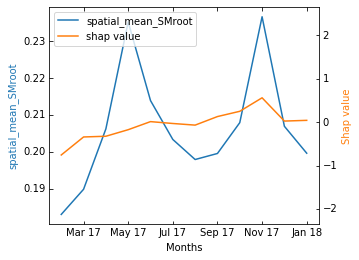

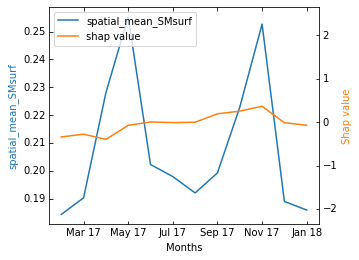

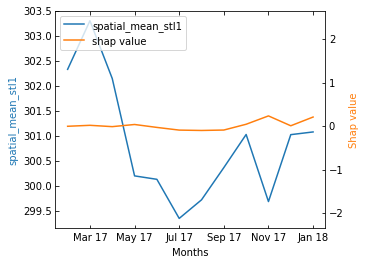

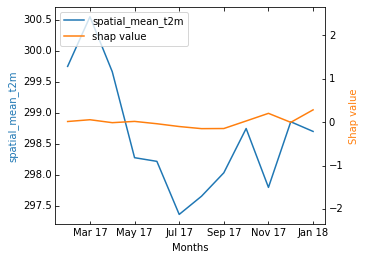

In [6]:
for var in variable_names:
    plt.clf()
    plot_shap_values(input_historical[0], shap_historical[0], variable_names, norm_dict, var, show=False,
                     pred_date=(np.where(input_pred_months[0] == 1)[0][0] + 1, 18))
    plt.savefig(analysis_dir/f'shap_plot_{var}.png', dpi=300, bbox_inches='tight')
    plt.show()